Setup

In [1]:
import pandas as pd
import time

data = pd.read_csv("../tutorials/ames_housing/data.csv")
data = data[data.GrLivArea < 4000]
y = data["SalePrice"]
X_orig = data.drop("SalePrice", axis="columns")
descriptions_df = pd.read_csv("../tutorials/ames_housing/feature_descriptions.csv")
descriptions = descriptions_df.set_index("Name").to_dict()["Description"]

Control Condition: No use of Pyreal, local feature contributions

In [2]:
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
import pickle
import shap

start = time.time()
def ames_transform(x):  #****
    x_transform = x.copy()
    x_transform.loc[:, "Alley"] = x_transform.loc[:, "Alley"].fillna("None")
    x_transform.loc[:, "BedroomAbvGr"] = x_transform.loc[:, "BedroomAbvGr"].fillna(0)
    x_transform.loc[:, "BsmtQual"] = x_transform.loc[:, "BsmtQual"].fillna("No")
    x_transform.loc[:, "BsmtCond"] = x_transform.loc[:, "BsmtCond"].fillna("No")
    x_transform.loc[:, "BsmtExposure"] = x_transform.loc[:, "BsmtExposure"].fillna("No")
    x_transform.loc[:, "BsmtFinType1"] = x_transform.loc[:, "BsmtFinType1"].fillna("No")
    x_transform.loc[:, "BsmtFinType2"] = x_transform.loc[:, "BsmtFinType2"].fillna("No")
    x_transform.loc[:, "BsmtFullBath"] = x_transform.loc[:, "BsmtFullBath"].fillna(0)
    x_transform.loc[:, "BsmtHalfBath"] = x_transform.loc[:, "BsmtHalfBath"].fillna(0)
    x_transform.loc[:, "BsmtUnfSF"] = x_transform.loc[:, "BsmtUnfSF"].fillna(0)
    x_transform.loc[:, "CentralAir"] = x_transform.loc[:, "CentralAir"].fillna("N")
    x_transform.loc[:, "Condition1"] = x_transform.loc[:, "Condition1"].fillna("Norm")
    x_transform.loc[:, "Condition2"] = x_transform.loc[:, "Condition2"].fillna("Norm")
    x_transform.loc[:, "EnclosedPorch"] = x_transform.loc[:, "EnclosedPorch"].fillna(0)
    x_transform.loc[:, "ExterCond"] = x_transform.loc[:, "ExterCond"].fillna("TA")
    x_transform.loc[:, "ExterQual"] = x_transform.loc[:, "ExterQual"].fillna("TA")
    x_transform.loc[:, "Fence"] = x_transform.loc[:, "Fence"].fillna("No")
    x_transform.loc[:, "FireplaceQu"] = x_transform.loc[:, "FireplaceQu"].fillna("No")
    x_transform.loc[:, "Fireplaces"] = x_transform.loc[:, "Fireplaces"].fillna(0)
    x_transform.loc[:, "Functional"] = x_transform.loc[:, "Functional"].fillna("Typ")
    x_transform.loc[:, "GarageType"] = x_transform.loc[:, "GarageType"].fillna("No")
    x_transform.loc[:, "GarageFinish"] = x_transform.loc[:, "GarageFinish"].fillna("No")
    x_transform.loc[:, "GarageQual"] = x_transform.loc[:, "GarageQual"].fillna("No")
    x_transform.loc[:, "GarageCond"] = x_transform.loc[:, "GarageCond"].fillna("No")
    x_transform.loc[:, "GarageArea"] = x_transform.loc[:, "GarageArea"].fillna(0)
    x_transform.loc[:, "GarageCars"] = x_transform.loc[:, "GarageCars"].fillna(0)
    x_transform.loc[:, "HalfBath"] = x_transform.loc[:, "HalfBath"].fillna(0)
    x_transform.loc[:, "HeatingQC"] = x_transform.loc[:, "HeatingQC"].fillna("TA")
    x_transform.loc[:, "KitchenAbvGr"] = x_transform.loc[:, "KitchenAbvGr"].fillna(0)
    x_transform.loc[:, "KitchenQual"] = x_transform.loc[:, "KitchenQual"].fillna("TA")
    x_transform.loc[:, "LotFrontage"] = x_transform.loc[:, "LotFrontage"].fillna(0)
    x_transform.loc[:, "LotShape"] = x_transform.loc[:, "LotShape"].fillna("Reg")
    x_transform.loc[:, "MasVnrType"] = x_transform.loc[:, "MasVnrType"].fillna("None")
    x_transform.loc[:, "MasVnrArea"] = x_transform.loc[:, "MasVnrArea"].fillna(0)
    x_transform.loc[:, "MiscFeature"] = x_transform.loc[:, "MiscFeature"].fillna("No")
    x_transform.loc[:, "MiscVal"] = x_transform.loc[:, "MiscVal"].fillna(0)
    x_transform.loc[:, "OpenPorchSF"] = x_transform.loc[:, "OpenPorchSF"].fillna(0)
    x_transform.loc[:, "PavedDrive"] = x_transform.loc[:, "PavedDrive"].fillna("N")
    x_transform.loc[:, "PoolQC"] = x_transform.loc[:, "PoolQC"].fillna("No")
    x_transform.loc[:, "PoolArea"] = x_transform.loc[:, "PoolArea"].fillna(0)
    x_transform.loc[:, "SaleCondition"] = x_transform.loc[:, "SaleCondition"].fillna("Normal")
    x_transform.loc[:, "ScreenPorch"] = x_transform.loc[:, "ScreenPorch"].fillna(0)
    x_transform.loc[:, "TotRmsAbvGrd"] = x_transform.loc[:, "TotRmsAbvGrd"].fillna(0)
    x_transform.loc[:, "Utilities"] = x_transform.loc[:, "Utilities"].fillna("AllPub")
    x_transform.loc[:, "WoodDeckSF"] = x_transform.loc[:, "WoodDeckSF"].fillna(0)
    x_transform.loc[:, "Electrical"] = x_transform.loc[:, "Electrical"].fillna("SBrkr")
    x_num = x_transform.select_dtypes(exclude=["object"])
    x_cat = x_transform.select_dtypes(include=["object"])
    x_num = x_num.fillna(x_num.median())
    return pd.concat([x_num, x_cat], axis=1)
X_explain = ames_transform(X_orig)
columns_to_encode = X_explain.select_dtypes(include=["object"]).columns
to_encode = X_explain[columns_to_encode]
ohe = SklearnOneHotEncoder(sparse=False).fit(to_encode)
encoded_columns = ohe.get_feature_names(to_encode.columns)
index = to_encode.index
encoded = ohe.transform(to_encode)
encoded_df = pd.DataFrame(encoded, columns=encoded_columns, index=index)
X_explain = pd.concat([X_explain.drop(columns_to_encode, axis="columns"), encoded_df], axis=1)
columns = X_explain.columns
model = pickle.load(open("../tutorials/ames_housing/model.pkl", "rb"))
explainer = shap.Explainer(model, X_explain)
explanation = explainer(X_explain.iloc[0:500])
explanation_df = pd.DataFrame(explanation.values, columns=columns)
for col in columns_to_encode:
    encoded_features = [item for item in encoded_columns if item.startswith(col+'_')]
    summed_contribution = explanation_df[encoded_features].sum(axis=1)
    explanation_df = explanation_df.drop(encoded_features, axis="columns")
    explanation_df[col] = summed_contribution
explanation_df = explanation_df.rename(descriptions, axis='columns')
shap_explanation = explanation_df #****
print(shap_explanation)
print("runtime:", time.time()-start)


           Id   Identifies the type of dwelling involved in the sale.  \
0    0.005569                                           0.001105        
1    0.005562                                           0.013559        
2    0.005554                                           0.001105        
3    0.005546                                          -0.002008        
4    0.005538                                           0.001105        
..        ...                                                ...        
495  0.001698                                           0.010446        
496  0.001690                                           0.013559        
497  0.001682                                           0.004219        
498  0.001674                                           0.013559        
499  0.001667                                           0.013559        

      Linear feet of street connected to property   Lot size in square feet  \
0                                        0.0

Trying to unpickle estimator Ridge from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


Experimental Condition: Using Pyreal

In [3]:
from pyreal.transformers import Transformer, OneHotEncoder, fit_transformers
from pyreal.explainers import LocalFeatureContribution

start = time.time()
class AmesHousingImputer(Transformer):  #****
    def data_transform(self, x):  #****
            x_transform = x.copy()
            x_transform.loc[:, "Alley"] = x_transform.loc[:, "Alley"].fillna("None")
            x_transform.loc[:, "BedroomAbvGr"] = x_transform.loc[:, "BedroomAbvGr"].fillna(0)
            x_transform.loc[:, "BsmtQual"] = x_transform.loc[:, "BsmtQual"].fillna("No")
            x_transform.loc[:, "BsmtCond"] = x_transform.loc[:, "BsmtCond"].fillna("No")
            x_transform.loc[:, "BsmtExposure"] = x_transform.loc[:, "BsmtExposure"].fillna("No")
            x_transform.loc[:, "BsmtFinType1"] = x_transform.loc[:, "BsmtFinType1"].fillna("No")
            x_transform.loc[:, "BsmtFinType2"] = x_transform.loc[:, "BsmtFinType2"].fillna("No")
            x_transform.loc[:, "BsmtFullBath"] = x_transform.loc[:, "BsmtFullBath"].fillna(0)
            x_transform.loc[:, "BsmtHalfBath"] = x_transform.loc[:, "BsmtHalfBath"].fillna(0)
            x_transform.loc[:, "BsmtUnfSF"] = x_transform.loc[:, "BsmtUnfSF"].fillna(0)
            x_transform.loc[:, "CentralAir"] = x_transform.loc[:, "CentralAir"].fillna("N")
            x_transform.loc[:, "Condition1"] = x_transform.loc[:, "Condition1"].fillna("Norm")
            x_transform.loc[:, "Condition2"] = x_transform.loc[:, "Condition2"].fillna("Norm")
            x_transform.loc[:, "EnclosedPorch"] = x_transform.loc[:, "EnclosedPorch"].fillna(0)
            x_transform.loc[:, "ExterCond"] = x_transform.loc[:, "ExterCond"].fillna("TA")
            x_transform.loc[:, "ExterQual"] = x_transform.loc[:, "ExterQual"].fillna("TA")
            x_transform.loc[:, "Fence"] = x_transform.loc[:, "Fence"].fillna("No")
            x_transform.loc[:, "FireplaceQu"] = x_transform.loc[:, "FireplaceQu"].fillna("No")
            x_transform.loc[:, "Fireplaces"] = x_transform.loc[:, "Fireplaces"].fillna(0)
            x_transform.loc[:, "Functional"] = x_transform.loc[:, "Functional"].fillna("Typ")
            x_transform.loc[:, "GarageType"] = x_transform.loc[:, "GarageType"].fillna("No")
            x_transform.loc[:, "GarageFinish"] = x_transform.loc[:, "GarageFinish"].fillna("No")
            x_transform.loc[:, "GarageQual"] = x_transform.loc[:, "GarageQual"].fillna("No")
            x_transform.loc[:, "GarageCond"] = x_transform.loc[:, "GarageCond"].fillna("No")
            x_transform.loc[:, "GarageArea"] = x_transform.loc[:, "GarageArea"].fillna(0)
            x_transform.loc[:, "GarageCars"] = x_transform.loc[:, "GarageCars"].fillna(0)
            x_transform.loc[:, "HalfBath"] = x_transform.loc[:, "HalfBath"].fillna(0)
            x_transform.loc[:, "HeatingQC"] = x_transform.loc[:, "HeatingQC"].fillna("TA")
            x_transform.loc[:, "KitchenAbvGr"] = x_transform.loc[:, "KitchenAbvGr"].fillna(0)
            x_transform.loc[:, "KitchenQual"] = x_transform.loc[:, "KitchenQual"].fillna("TA")
            x_transform.loc[:, "LotFrontage"] = x_transform.loc[:, "LotFrontage"].fillna(0)
            x_transform.loc[:, "LotShape"] = x_transform.loc[:, "LotShape"].fillna("Reg")
            x_transform.loc[:, "MasVnrType"] = x_transform.loc[:, "MasVnrType"].fillna("None")
            x_transform.loc[:, "MasVnrArea"] = x_transform.loc[:, "MasVnrArea"].fillna(0)
            x_transform.loc[:, "MiscFeature"] = x_transform.loc[:, "MiscFeature"].fillna("No")
            x_transform.loc[:, "MiscVal"] = x_transform.loc[:, "MiscVal"].fillna(0)
            x_transform.loc[:, "OpenPorchSF"] = x_transform.loc[:, "OpenPorchSF"].fillna(0)
            x_transform.loc[:, "PavedDrive"] = x_transform.loc[:, "PavedDrive"].fillna("N")
            x_transform.loc[:, "PoolQC"] = x_transform.loc[:, "PoolQC"].fillna("No")
            x_transform.loc[:, "PoolArea"] = x_transform.loc[:, "PoolArea"].fillna(0)
            x_transform.loc[:, "SaleCondition"] = x_transform.loc[:, "SaleCondition"].fillna("Normal")
            x_transform.loc[:, "ScreenPorch"] = x_transform.loc[:, "ScreenPorch"].fillna(0)
            x_transform.loc[:, "TotRmsAbvGrd"] = x_transform.loc[:, "TotRmsAbvGrd"].fillna(0)
            x_transform.loc[:, "Utilities"] = x_transform.loc[:, "Utilities"].fillna("AllPub")
            x_transform.loc[:, "WoodDeckSF"] = x_transform.loc[:, "WoodDeckSF"].fillna(0)
            x_transform.loc[:, "Electrical"] = x_transform.loc[:, "Electrical"].fillna("SBrkr")
            x_num = x_transform.select_dtypes(exclude=["object"])
            x_cat = x_transform.select_dtypes(include=["object"])
            x_num = x_num.fillna(x_num.median())
            return pd.concat([x_num, x_cat], axis=1)
object_columns = X_orig.select_dtypes(include=["object"]).columns
transformers = [AmesHousingImputer(), OneHotEncoder(object_columns)]
fit_transformers(transformers, X_orig)
lfc = LocalFeatureContribution(model="../tutorials/ames_housing/model.pkl", x_train_orig=X_orig, y_orig=y, e_algorithm="shap", transformers=transformers, feature_descriptions=descriptions, fit_on_init=True)
pyreal_explanation = lfc.produce(X_orig.iloc[0:500])
print(pyreal_explanation)
print("runtime:", time.time()-start)


Trying to unpickle estimator Ridge from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator Ridge from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


Transformer <class '__main__.AmesHousingImputer'> does not have an implemented inverse_transform_explanation_additive_contributions function. Defaulting to no change in explanation. If this causes a break,you may want to add an interpret=True flag to this transformer or redefine this function to throw a BreakingTransformError.
(           Id   Identifies the type of dwelling involved in the sale.  \
0    0.005569                                           0.001105        
1    0.005562                                           0.013559        
2    0.005554                                           0.001105        
3    0.005546                                          -0.002008        
4    0.005538                                           0.001105        
..        ...                                                ...        
495  0.001698                                           0.010446        
496  0.001690                                           0.013559        
497  0.001682

In [4]:
print("Difference in explanations:  ")
pyreal_explanation[0].compare(shap_explanation)

Difference in explanations:  


Year garage was built          
                      self     other
39               -0.000712 -0.000109
48               -0.000712 -0.000109
78               -0.000712 -0.000109
88               -0.000712 -0.000109
89               -0.000712 -0.000109
99               -0.000712 -0.000109
108              -0.000712 -0.000109
125              -0.000712 -0.000109
127              -0.000712 -0.000109
140              -0.000712 -0.000109
148              -0.000712 -0.000109
155              -0.000712 -0.000109
163              -0.000712 -0.000109
165              -0.000712 -0.000109
198              -0.000712 -0.000109
210              -0.000712 -0.000109
241              -0.000712 -0.000109
250              -0.000712 -0.000109
287              -0.000712 -0.000109
291              -0.000712 -0.000109
307              -0.000712 -0.000109
375              -0.000712 -0.000109
386              -0.000712 -0.000109
393              -0.000712 -0.000109
431              -0.000712 -0.000109
434              -0.000712 -0.000109
441              -0.000712 -0.000109
464              -0.000712 -0.000109
495              -0.000712 -0.000109

Control Condition: No use of Pyreal, global feature importance

In [5]:
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
import numpy as np
import pickle
import shap

start = time.time()
def ames_transform(x):  # ****
    x_transform = x.copy()
    x_transform.loc[:, "Alley"] = x_transform.loc[:, "Alley"].fillna("None")
    x_transform.loc[:, "BedroomAbvGr"] = x_transform.loc[:, "BedroomAbvGr"].fillna(0)
    x_transform.loc[:, "BsmtQual"] = x_transform.loc[:, "BsmtQual"].fillna("No")
    x_transform.loc[:, "BsmtCond"] = x_transform.loc[:, "BsmtCond"].fillna("No")
    x_transform.loc[:, "BsmtExposure"] = x_transform.loc[:, "BsmtExposure"].fillna("No")
    x_transform.loc[:, "BsmtFinType1"] = x_transform.loc[:, "BsmtFinType1"].fillna("No")
    x_transform.loc[:, "BsmtFinType2"] = x_transform.loc[:, "BsmtFinType2"].fillna("No")
    x_transform.loc[:, "BsmtFullBath"] = x_transform.loc[:, "BsmtFullBath"].fillna(0)
    x_transform.loc[:, "BsmtHalfBath"] = x_transform.loc[:, "BsmtHalfBath"].fillna(0)
    x_transform.loc[:, "BsmtUnfSF"] = x_transform.loc[:, "BsmtUnfSF"].fillna(0)
    x_transform.loc[:, "CentralAir"] = x_transform.loc[:, "CentralAir"].fillna("N")
    x_transform.loc[:, "Condition1"] = x_transform.loc[:, "Condition1"].fillna("Norm")
    x_transform.loc[:, "Condition2"] = x_transform.loc[:, "Condition2"].fillna("Norm")
    x_transform.loc[:, "EnclosedPorch"] = x_transform.loc[:, "EnclosedPorch"].fillna(0)
    x_transform.loc[:, "ExterCond"] = x_transform.loc[:, "ExterCond"].fillna("TA")
    x_transform.loc[:, "ExterQual"] = x_transform.loc[:, "ExterQual"].fillna("TA")
    x_transform.loc[:, "Fence"] = x_transform.loc[:, "Fence"].fillna("No")
    x_transform.loc[:, "FireplaceQu"] = x_transform.loc[:, "FireplaceQu"].fillna("No")
    x_transform.loc[:, "Fireplaces"] = x_transform.loc[:, "Fireplaces"].fillna(0)
    x_transform.loc[:, "Functional"] = x_transform.loc[:, "Functional"].fillna("Typ")
    x_transform.loc[:, "GarageType"] = x_transform.loc[:, "GarageType"].fillna("No")
    x_transform.loc[:, "GarageFinish"] = x_transform.loc[:, "GarageFinish"].fillna("No")
    x_transform.loc[:, "GarageQual"] = x_transform.loc[:, "GarageQual"].fillna("No")
    x_transform.loc[:, "GarageCond"] = x_transform.loc[:, "GarageCond"].fillna("No")
    x_transform.loc[:, "GarageArea"] = x_transform.loc[:, "GarageArea"].fillna(0)
    x_transform.loc[:, "GarageCars"] = x_transform.loc[:, "GarageCars"].fillna(0)
    x_transform.loc[:, "HalfBath"] = x_transform.loc[:, "HalfBath"].fillna(0)
    x_transform.loc[:, "HeatingQC"] = x_transform.loc[:, "HeatingQC"].fillna("TA")
    x_transform.loc[:, "KitchenAbvGr"] = x_transform.loc[:, "KitchenAbvGr"].fillna(0)
    x_transform.loc[:, "KitchenQual"] = x_transform.loc[:, "KitchenQual"].fillna("TA")
    x_transform.loc[:, "LotFrontage"] = x_transform.loc[:, "LotFrontage"].fillna(0)
    x_transform.loc[:, "LotShape"] = x_transform.loc[:, "LotShape"].fillna("Reg")
    x_transform.loc[:, "MasVnrType"] = x_transform.loc[:, "MasVnrType"].fillna("None")
    x_transform.loc[:, "MasVnrArea"] = x_transform.loc[:, "MasVnrArea"].fillna(0)
    x_transform.loc[:, "MiscFeature"] = x_transform.loc[:, "MiscFeature"].fillna("No")
    x_transform.loc[:, "MiscVal"] = x_transform.loc[:, "MiscVal"].fillna(0)
    x_transform.loc[:, "OpenPorchSF"] = x_transform.loc[:, "OpenPorchSF"].fillna(0)
    x_transform.loc[:, "PavedDrive"] = x_transform.loc[:, "PavedDrive"].fillna("N")
    x_transform.loc[:, "PoolQC"] = x_transform.loc[:, "PoolQC"].fillna("No")
    x_transform.loc[:, "PoolArea"] = x_transform.loc[:, "PoolArea"].fillna(0)
    x_transform.loc[:, "SaleCondition"] = x_transform.loc[:, "SaleCondition"].fillna("Normal")
    x_transform.loc[:, "ScreenPorch"] = x_transform.loc[:, "ScreenPorch"].fillna(0)
    x_transform.loc[:, "TotRmsAbvGrd"] = x_transform.loc[:, "TotRmsAbvGrd"].fillna(0)
    x_transform.loc[:, "Utilities"] = x_transform.loc[:, "Utilities"].fillna("AllPub")
    x_transform.loc[:, "WoodDeckSF"] = x_transform.loc[:, "WoodDeckSF"].fillna(0)
    x_transform.loc[:, "Electrical"] = x_transform.loc[:, "Electrical"].fillna("SBrkr")
    x_num = x_transform.select_dtypes(exclude=["object"])
    x_cat = x_transform.select_dtypes(include=["object"])
    x_num = x_num.fillna(x_num.median())
    return pd.concat([x_num, x_cat], axis=1)
X_explain = ames_transform(X_orig)
columns_to_encode = X_explain.select_dtypes(include=["object"]).columns
to_encode = X_explain[columns_to_encode]
ohe = SklearnOneHotEncoder(sparse=False).fit(to_encode)
encoded_columns = ohe.get_feature_names(to_encode.columns)
index = to_encode.index
encoded = ohe.transform(to_encode)
encoded_df = pd.DataFrame(encoded, columns=encoded_columns, index=index)
X_explain = pd.concat([X_explain.drop(columns_to_encode, axis="columns"), encoded_df], axis=1)
columns = X_explain.columns
model = pickle.load(open("../tutorials/ames_housing/model.pkl", "rb"))
explainer = shap.Explainer(model, X_explain)
explanation = explainer(X_explain)
explanation = np.mean(np.absolute(explanation.values), axis=0).reshape(1, -1)
explanation_df = pd.DataFrame(explanation, columns=columns)
for col in columns_to_encode:
    encoded_features = [item for item in encoded_columns if item.startswith(col+'_')]
    summed_contribution = explanation_df[encoded_features].sum(axis=1)
    explanation_df = explanation_df.drop(encoded_features, axis="columns")
    explanation_df[col] = summed_contribution
explanation_df = explanation_df.rename(descriptions, axis='columns')
shap_explanation = explanation_df #****
print(shap_explanation)
print("runtime:", time.time()-start)


         Id   Identifies the type of dwelling involved in the sale.  \
0  0.002857                                           0.010317        

    Linear feet of street connected to property   Lot size in square feet  \
0                                      0.001278                  0.010305   

    Rates the overall material and finish of the house  \
0                                           0.045525     

    Rates the overall condition of the house   Original construction date  \
0                                   0.030879                     0.043923   

    Remodel date (same as construction date if no remodeling or additions)  \
0                                           0.015309                         

    Masonry veneer area in square feet   Type 1 finished square feet  ...  \
0                             0.000447                      0.019705  ...   

    Garage location   Interior finish of the garage   Garage quality  \
0          0.019149                        0.0

Trying to unpickle estimator Ridge from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


Experimental condition: using Pyreal

In [6]:
from pyreal.transformers import Transformer, OneHotEncoder, fit_transformers
from pyreal.explainers import GlobalFeatureImportance

start = time.time()
class AmesHousingImputer(Transformer):  #****
    def data_transform(self, x):  #****
            x_transform = x.copy()
            x_transform.loc[:, "Alley"] = x_transform.loc[:, "Alley"].fillna("None")
            x_transform.loc[:, "BedroomAbvGr"] = x_transform.loc[:, "BedroomAbvGr"].fillna(0)
            x_transform.loc[:, "BsmtQual"] = x_transform.loc[:, "BsmtQual"].fillna("No")
            x_transform.loc[:, "BsmtCond"] = x_transform.loc[:, "BsmtCond"].fillna("No")
            x_transform.loc[:, "BsmtExposure"] = x_transform.loc[:, "BsmtExposure"].fillna("No")
            x_transform.loc[:, "BsmtFinType1"] = x_transform.loc[:, "BsmtFinType1"].fillna("No")
            x_transform.loc[:, "BsmtFinType2"] = x_transform.loc[:, "BsmtFinType2"].fillna("No")
            x_transform.loc[:, "BsmtFullBath"] = x_transform.loc[:, "BsmtFullBath"].fillna(0)
            x_transform.loc[:, "BsmtHalfBath"] = x_transform.loc[:, "BsmtHalfBath"].fillna(0)
            x_transform.loc[:, "BsmtUnfSF"] = x_transform.loc[:, "BsmtUnfSF"].fillna(0)
            x_transform.loc[:, "CentralAir"] = x_transform.loc[:, "CentralAir"].fillna("N")
            x_transform.loc[:, "Condition1"] = x_transform.loc[:, "Condition1"].fillna("Norm")
            x_transform.loc[:, "Condition2"] = x_transform.loc[:, "Condition2"].fillna("Norm")
            x_transform.loc[:, "EnclosedPorch"] = x_transform.loc[:, "EnclosedPorch"].fillna(0)
            x_transform.loc[:, "ExterCond"] = x_transform.loc[:, "ExterCond"].fillna("TA")
            x_transform.loc[:, "ExterQual"] = x_transform.loc[:, "ExterQual"].fillna("TA")
            x_transform.loc[:, "Fence"] = x_transform.loc[:, "Fence"].fillna("No")
            x_transform.loc[:, "FireplaceQu"] = x_transform.loc[:, "FireplaceQu"].fillna("No")
            x_transform.loc[:, "Fireplaces"] = x_transform.loc[:, "Fireplaces"].fillna(0)
            x_transform.loc[:, "Functional"] = x_transform.loc[:, "Functional"].fillna("Typ")
            x_transform.loc[:, "GarageType"] = x_transform.loc[:, "GarageType"].fillna("No")
            x_transform.loc[:, "GarageFinish"] = x_transform.loc[:, "GarageFinish"].fillna("No")
            x_transform.loc[:, "GarageQual"] = x_transform.loc[:, "GarageQual"].fillna("No")
            x_transform.loc[:, "GarageCond"] = x_transform.loc[:, "GarageCond"].fillna("No")
            x_transform.loc[:, "GarageArea"] = x_transform.loc[:, "GarageArea"].fillna(0)
            x_transform.loc[:, "GarageCars"] = x_transform.loc[:, "GarageCars"].fillna(0)
            x_transform.loc[:, "HalfBath"] = x_transform.loc[:, "HalfBath"].fillna(0)
            x_transform.loc[:, "HeatingQC"] = x_transform.loc[:, "HeatingQC"].fillna("TA")
            x_transform.loc[:, "KitchenAbvGr"] = x_transform.loc[:, "KitchenAbvGr"].fillna(0)
            x_transform.loc[:, "KitchenQual"] = x_transform.loc[:, "KitchenQual"].fillna("TA")
            x_transform.loc[:, "LotFrontage"] = x_transform.loc[:, "LotFrontage"].fillna(0)
            x_transform.loc[:, "LotShape"] = x_transform.loc[:, "LotShape"].fillna("Reg")
            x_transform.loc[:, "MasVnrType"] = x_transform.loc[:, "MasVnrType"].fillna("None")
            x_transform.loc[:, "MasVnrArea"] = x_transform.loc[:, "MasVnrArea"].fillna(0)
            x_transform.loc[:, "MiscFeature"] = x_transform.loc[:, "MiscFeature"].fillna("No")
            x_transform.loc[:, "MiscVal"] = x_transform.loc[:, "MiscVal"].fillna(0)
            x_transform.loc[:, "OpenPorchSF"] = x_transform.loc[:, "OpenPorchSF"].fillna(0)
            x_transform.loc[:, "PavedDrive"] = x_transform.loc[:, "PavedDrive"].fillna("N")
            x_transform.loc[:, "PoolQC"] = x_transform.loc[:, "PoolQC"].fillna("No")
            x_transform.loc[:, "PoolArea"] = x_transform.loc[:, "PoolArea"].fillna(0)
            x_transform.loc[:, "SaleCondition"] = x_transform.loc[:, "SaleCondition"].fillna("Normal")
            x_transform.loc[:, "ScreenPorch"] = x_transform.loc[:, "ScreenPorch"].fillna(0)
            x_transform.loc[:, "TotRmsAbvGrd"] = x_transform.loc[:, "TotRmsAbvGrd"].fillna(0)
            x_transform.loc[:, "Utilities"] = x_transform.loc[:, "Utilities"].fillna("AllPub")
            x_transform.loc[:, "WoodDeckSF"] = x_transform.loc[:, "WoodDeckSF"].fillna(0)
            x_transform.loc[:, "Electrical"] = x_transform.loc[:, "Electrical"].fillna("SBrkr")
            x_num = x_transform.select_dtypes(exclude=["object"])
            x_cat = x_transform.select_dtypes(include=["object"])
            x_num = x_num.fillna(x_num.median())
            return pd.concat([x_num, x_cat], axis=1)
object_columns = X_orig.select_dtypes(include=["object"]).columns
transformers = [AmesHousingImputer(), OneHotEncoder(object_columns)]
fit_transformers(transformers, X_orig)
gfi = GlobalFeatureImportance(model="../tutorials/ames_housing/model.pkl", x_train_orig=X_orig, y_orig=y, e_algorithm="shap", transformers=transformers, feature_descriptions=descriptions, fit_on_init=True)
pyreal_explanation = gfi.produce()
print(pyreal_explanation)
print("runtime:", time.time()-start)


Trying to unpickle estimator Ridge from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator Ridge from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


Transformer <class '__main__.AmesHousingImputer'> does not have an implemented inverse_transform_explanation_additive_contributions function. Defaulting to no change in explanation. If this causes a break,you may want to add an interpret=True flag to this transformer or redefine this function to throw a BreakingTransformError.
         Id   Identifies the type of dwelling involved in the sale.  \
0  0.002857                                           0.010317        

    Linear feet of street connected to property   Lot size in square feet  \
0                                      0.001278                  0.010305   

    Rates the overall material and finish of the house  \
0                                           0.045525     

    Rates the overall condition of the house   Original construction date  \
0                                   0.030879                     0.043923   

    Remodel date (same as construction date if no remodeling or additions)  \
0                      

In [7]:
print("Difference in explanations:  ")
pyreal_explanation.compare(shap_explanation)


Difference in explanations:  


Id            Identifies the type of dwelling involved in the sale.  \
       self     other                                                   self   
0  0.002857  0.002857                                           0.010317       

             Linear feet of street connected to property            \
      other                                         self     other   
0  0.010317                                     0.001278  0.001278   

   Lot size in square feet            \
                      self     other   
0                 0.010305  0.010305   

   Rates the overall material and finish of the house            ...  \
                                                 self     other  ...   
0                                           0.045525   0.045525  ...   

   Paved driveway            Fence quality            \
             self     other           self     other   
0        0.002588  0.002588       0.008357  0.008357   

   Miscellaneous feature not covered in other categories            \
                                                    self     other   
0                                           0.011056      0.011056   

   Type of sale            Condition of sale            
           self     other               self     other  
0      0.020693  0.020693           0.020531  0.020531  

[1 rows x 150 columns]

Experimental condition: using Pyreal

Trying to unpickle estimator Ridge from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator Ridge from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


runtime: 0.3986670970916748


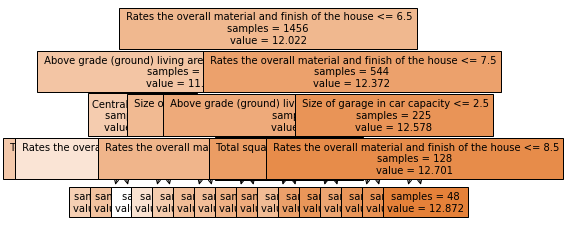

In [8]:
from pyreal.transformers import Transformer, OneHotEncoder, fit_transformers
from pyreal.explainers import DecisionTreeExplainer

start = time.time()
class AmesHousingImputer(Transformer):  #****
    def data_transform(self, x):  #****
            x_transform = x.copy()
            x_transform.loc[:, "Alley"] = x_transform.loc[:, "Alley"].fillna("None")
            x_transform.loc[:, "BedroomAbvGr"] = x_transform.loc[:, "BedroomAbvGr"].fillna(0)
            x_transform.loc[:, "BsmtQual"] = x_transform.loc[:, "BsmtQual"].fillna("No")
            x_transform.loc[:, "BsmtCond"] = x_transform.loc[:, "BsmtCond"].fillna("No")
            x_transform.loc[:, "BsmtExposure"] = x_transform.loc[:, "BsmtExposure"].fillna("No")
            x_transform.loc[:, "BsmtFinType1"] = x_transform.loc[:, "BsmtFinType1"].fillna("No")
            x_transform.loc[:, "BsmtFinType2"] = x_transform.loc[:, "BsmtFinType2"].fillna("No")
            x_transform.loc[:, "BsmtFullBath"] = x_transform.loc[:, "BsmtFullBath"].fillna(0)
            x_transform.loc[:, "BsmtHalfBath"] = x_transform.loc[:, "BsmtHalfBath"].fillna(0)
            x_transform.loc[:, "BsmtUnfSF"] = x_transform.loc[:, "BsmtUnfSF"].fillna(0)
            x_transform.loc[:, "CentralAir"] = x_transform.loc[:, "CentralAir"].fillna("N")
            x_transform.loc[:, "Condition1"] = x_transform.loc[:, "Condition1"].fillna("Norm")
            x_transform.loc[:, "Condition2"] = x_transform.loc[:, "Condition2"].fillna("Norm")
            x_transform.loc[:, "EnclosedPorch"] = x_transform.loc[:, "EnclosedPorch"].fillna(0)
            x_transform.loc[:, "ExterCond"] = x_transform.loc[:, "ExterCond"].fillna("TA")
            x_transform.loc[:, "ExterQual"] = x_transform.loc[:, "ExterQual"].fillna("TA")
            x_transform.loc[:, "Fence"] = x_transform.loc[:, "Fence"].fillna("No")
            x_transform.loc[:, "FireplaceQu"] = x_transform.loc[:, "FireplaceQu"].fillna("No")
            x_transform.loc[:, "Fireplaces"] = x_transform.loc[:, "Fireplaces"].fillna(0)
            x_transform.loc[:, "Functional"] = x_transform.loc[:, "Functional"].fillna("Typ")
            x_transform.loc[:, "GarageType"] = x_transform.loc[:, "GarageType"].fillna("No")
            x_transform.loc[:, "GarageFinish"] = x_transform.loc[:, "GarageFinish"].fillna("No")
            x_transform.loc[:, "GarageQual"] = x_transform.loc[:, "GarageQual"].fillna("No")
            x_transform.loc[:, "GarageCond"] = x_transform.loc[:, "GarageCond"].fillna("No")
            x_transform.loc[:, "GarageArea"] = x_transform.loc[:, "GarageArea"].fillna(0)
            x_transform.loc[:, "GarageCars"] = x_transform.loc[:, "GarageCars"].fillna(0)
            x_transform.loc[:, "HalfBath"] = x_transform.loc[:, "HalfBath"].fillna(0)
            x_transform.loc[:, "HeatingQC"] = x_transform.loc[:, "HeatingQC"].fillna("TA")
            x_transform.loc[:, "KitchenAbvGr"] = x_transform.loc[:, "KitchenAbvGr"].fillna(0)
            x_transform.loc[:, "KitchenQual"] = x_transform.loc[:, "KitchenQual"].fillna("TA")
            x_transform.loc[:, "LotFrontage"] = x_transform.loc[:, "LotFrontage"].fillna(0)
            x_transform.loc[:, "LotShape"] = x_transform.loc[:, "LotShape"].fillna("Reg")
            x_transform.loc[:, "MasVnrType"] = x_transform.loc[:, "MasVnrType"].fillna("None")
            x_transform.loc[:, "MasVnrArea"] = x_transform.loc[:, "MasVnrArea"].fillna(0)
            x_transform.loc[:, "MiscFeature"] = x_transform.loc[:, "MiscFeature"].fillna("No")
            x_transform.loc[:, "MiscVal"] = x_transform.loc[:, "MiscVal"].fillna(0)
            x_transform.loc[:, "OpenPorchSF"] = x_transform.loc[:, "OpenPorchSF"].fillna(0)
            x_transform.loc[:, "PavedDrive"] = x_transform.loc[:, "PavedDrive"].fillna("N")
            x_transform.loc[:, "PoolQC"] = x_transform.loc[:, "PoolQC"].fillna("No")
            x_transform.loc[:, "PoolArea"] = x_transform.loc[:, "PoolArea"].fillna(0)
            x_transform.loc[:, "SaleCondition"] = x_transform.loc[:, "SaleCondition"].fillna("Normal")
            x_transform.loc[:, "ScreenPorch"] = x_transform.loc[:, "ScreenPorch"].fillna(0)
            x_transform.loc[:, "TotRmsAbvGrd"] = x_transform.loc[:, "TotRmsAbvGrd"].fillna(0)
            x_transform.loc[:, "Utilities"] = x_transform.loc[:, "Utilities"].fillna("AllPub")
            x_transform.loc[:, "WoodDeckSF"] = x_transform.loc[:, "WoodDeckSF"].fillna(0)
            x_transform.loc[:, "Electrical"] = x_transform.loc[:, "Electrical"].fillna("SBrkr")
            x_num = x_transform.select_dtypes(exclude=["object"])
            x_cat = x_transform.select_dtypes(include=["object"])
            x_num = x_num.fillna(x_num.median())
            return pd.concat([x_num, x_cat], axis=1)
object_columns = X_orig.select_dtypes(include=["object"]).columns
transformers = [AmesHousingImputer(), OneHotEncoder(object_columns)]
fit_transformers(transformers, X_orig)
dte = DecisionTreeExplainer(model="../tutorials/ames_housing/model.pkl", x_train_orig=X_orig, is_classifier=False, max_depth=4, transformers=transformers, feature_descriptions=descriptions, fit_on_init=True)
pyreal_explanation = dte.produce()
print("runtime:", time.time()-start)


from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plot_tree(pyreal_explanation, feature_names=dte.return_features(), impurity=False, fontsize=10, filled=True)
plt.show()


No pyreal condition, decision tree explainer

(1456, 301)
runtime: 0.14609193801879883


Trying to unpickle estimator Ridge from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


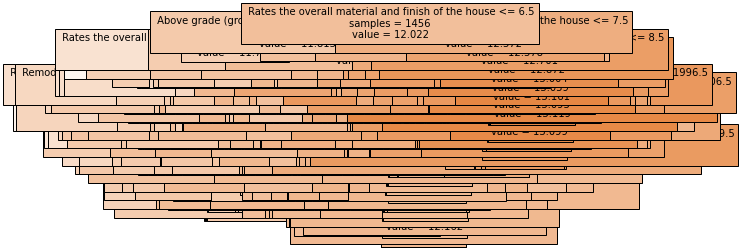

In [9]:
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
from sklearn import tree
import pickle

start = time.time()
def ames_transform(x):
        x_transform = x.copy()
        x_transform.loc[:, "Alley"] = x_transform.loc[:, "Alley"].fillna("None")
        x_transform.loc[:, "BedroomAbvGr"] = x_transform.loc[:, "BedroomAbvGr"].fillna(0)
        x_transform.loc[:, "BsmtQual"] = x_transform.loc[:, "BsmtQual"].fillna("No")
        x_transform.loc[:, "BsmtCond"] = x_transform.loc[:, "BsmtCond"].fillna("No")
        x_transform.loc[:, "BsmtExposure"] = x_transform.loc[:, "BsmtExposure"].fillna("No")
        x_transform.loc[:, "BsmtFinType1"] = x_transform.loc[:, "BsmtFinType1"].fillna("No")
        x_transform.loc[:, "BsmtFinType2"] = x_transform.loc[:, "BsmtFinType2"].fillna("No")
        x_transform.loc[:, "BsmtFullBath"] = x_transform.loc[:, "BsmtFullBath"].fillna(0)
        x_transform.loc[:, "BsmtHalfBath"] = x_transform.loc[:, "BsmtHalfBath"].fillna(0)
        x_transform.loc[:, "BsmtUnfSF"] = x_transform.loc[:, "BsmtUnfSF"].fillna(0)
        x_transform.loc[:, "CentralAir"] = x_transform.loc[:, "CentralAir"].fillna("N")
        x_transform.loc[:, "Condition1"] = x_transform.loc[:, "Condition1"].fillna("Norm")
        x_transform.loc[:, "Condition2"] = x_transform.loc[:, "Condition2"].fillna("Norm")
        x_transform.loc[:, "EnclosedPorch"] = x_transform.loc[:, "EnclosedPorch"].fillna(0)
        x_transform.loc[:, "ExterCond"] = x_transform.loc[:, "ExterCond"].fillna("TA")
        x_transform.loc[:, "ExterQual"] = x_transform.loc[:, "ExterQual"].fillna("TA")
        x_transform.loc[:, "Fence"] = x_transform.loc[:, "Fence"].fillna("No")
        x_transform.loc[:, "FireplaceQu"] = x_transform.loc[:, "FireplaceQu"].fillna("No")
        x_transform.loc[:, "Fireplaces"] = x_transform.loc[:, "Fireplaces"].fillna(0)
        x_transform.loc[:, "Functional"] = x_transform.loc[:, "Functional"].fillna("Typ")
        x_transform.loc[:, "GarageType"] = x_transform.loc[:, "GarageType"].fillna("No")
        x_transform.loc[:, "GarageFinish"] = x_transform.loc[:, "GarageFinish"].fillna("No")
        x_transform.loc[:, "GarageQual"] = x_transform.loc[:, "GarageQual"].fillna("No")
        x_transform.loc[:, "GarageCond"] = x_transform.loc[:, "GarageCond"].fillna("No")
        x_transform.loc[:, "GarageArea"] = x_transform.loc[:, "GarageArea"].fillna(0)
        x_transform.loc[:, "GarageCars"] = x_transform.loc[:, "GarageCars"].fillna(0)
        x_transform.loc[:, "HalfBath"] = x_transform.loc[:, "HalfBath"].fillna(0)
        x_transform.loc[:, "HeatingQC"] = x_transform.loc[:, "HeatingQC"].fillna("TA")
        x_transform.loc[:, "KitchenAbvGr"] = x_transform.loc[:, "KitchenAbvGr"].fillna(0)
        x_transform.loc[:, "KitchenQual"] = x_transform.loc[:, "KitchenQual"].fillna("TA")
        x_transform.loc[:, "LotFrontage"] = x_transform.loc[:, "LotFrontage"].fillna(0)
        x_transform.loc[:, "LotShape"] = x_transform.loc[:, "LotShape"].fillna("Reg")
        x_transform.loc[:, "MasVnrType"] = x_transform.loc[:, "MasVnrType"].fillna("None")
        x_transform.loc[:, "MasVnrArea"] = x_transform.loc[:, "MasVnrArea"].fillna(0)
        x_transform.loc[:, "MiscFeature"] = x_transform.loc[:, "MiscFeature"].fillna("No")
        x_transform.loc[:, "MiscVal"] = x_transform.loc[:, "MiscVal"].fillna(0)
        x_transform.loc[:, "OpenPorchSF"] = x_transform.loc[:, "OpenPorchSF"].fillna(0)
        x_transform.loc[:, "PavedDrive"] = x_transform.loc[:, "PavedDrive"].fillna("N")
        x_transform.loc[:, "PoolQC"] = x_transform.loc[:, "PoolQC"].fillna("No")
        x_transform.loc[:, "PoolArea"] = x_transform.loc[:, "PoolArea"].fillna(0)
        x_transform.loc[:, "SaleCondition"] = x_transform.loc[:, "SaleCondition"].fillna("Normal")
        x_transform.loc[:, "ScreenPorch"] = x_transform.loc[:, "ScreenPorch"].fillna(0)
        x_transform.loc[:, "TotRmsAbvGrd"] = x_transform.loc[:, "TotRmsAbvGrd"].fillna(0)
        x_transform.loc[:, "Utilities"] = x_transform.loc[:, "Utilities"].fillna("AllPub")
        x_transform.loc[:, "WoodDeckSF"] = x_transform.loc[:, "WoodDeckSF"].fillna(0)
        x_transform.loc[:, "Electrical"] = x_transform.loc[:, "Electrical"].fillna("SBrkr")
        x_num = x_transform.select_dtypes(exclude=["object"])
        x_cat = x_transform.select_dtypes(include=["object"])
        x_num = x_num.fillna(x_num.median())
        return pd.concat([x_num, x_cat], axis=1)
X_explain = ames_transform(X_orig)
columns_to_encode = X_explain.select_dtypes(include=["object"]).columns
to_encode = X_explain[columns_to_encode]
ohe = SklearnOneHotEncoder(sparse=False).fit(to_encode)
encoded_columns = ohe.get_feature_names(to_encode.columns)
index = to_encode.index
encoded = ohe.transform(to_encode)
encoded_df = pd.DataFrame(encoded, columns=encoded_columns, index=index)
X_explain = pd.concat([X_explain.drop(columns_to_encode, axis="columns"), encoded_df], axis=1)
print(X_explain.shape)
sklearn_explanation = tree.DecisionTreeRegressor()
model = pickle.load(open("../tutorials/ames_housing/model.pkl", "rb"))
results = model.predict(X_explain)
sklearn_explanation.fit(X_explain, model.predict(X_explain))
print("runtime:", time.time()-start)

plot_tree(sklearn_explanation, feature_names=dte.return_features(), impurity=False, fontsize=10, filled=True)
plt.show()